### 1. Import corresponding modules

In [1]:
import obspy
import seispy
import numpy as np
import matplotlib.pyplot as plt

### 2. Read SAC files with 3 components (ENZ)
You should perpare teleseismic data if SAC format (ENZ) and read them via obspy. To facilitate the follow-up, you'd better write positions of the station and the event into SAC header (i.e., `stla`, `stlo`, `evla`, `evlo` and `evdp`).

In [17]:
st = obspy.read('tele/*.101.*.SAC')

### 3. Pre-process for raw data
You should remove the mean offset and linear trend of the waveforms, then filtered them with a Butterworth bandpass filter in the range of 0.05–2 Hz. The figures show a comparison between the raw data and the data after pre-process

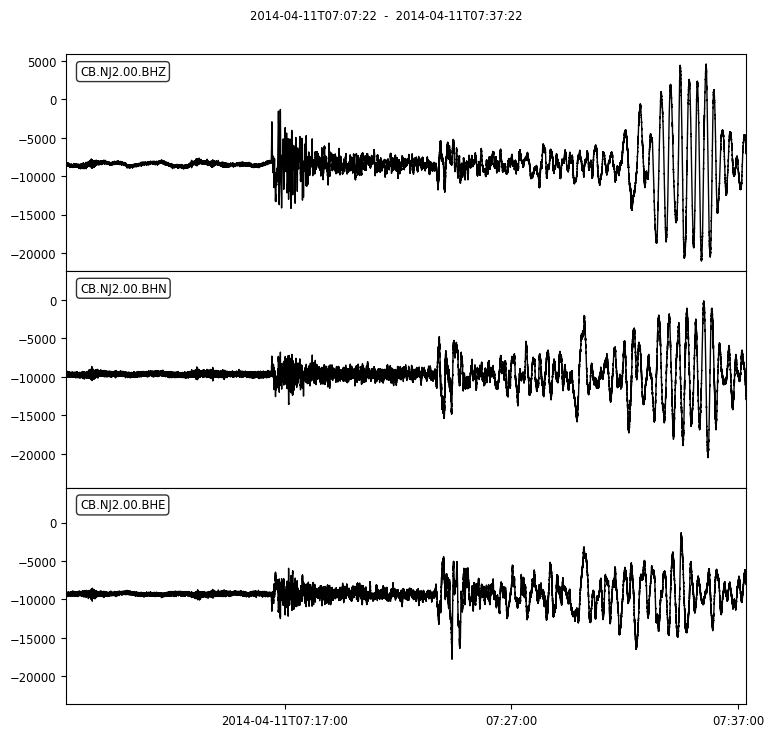

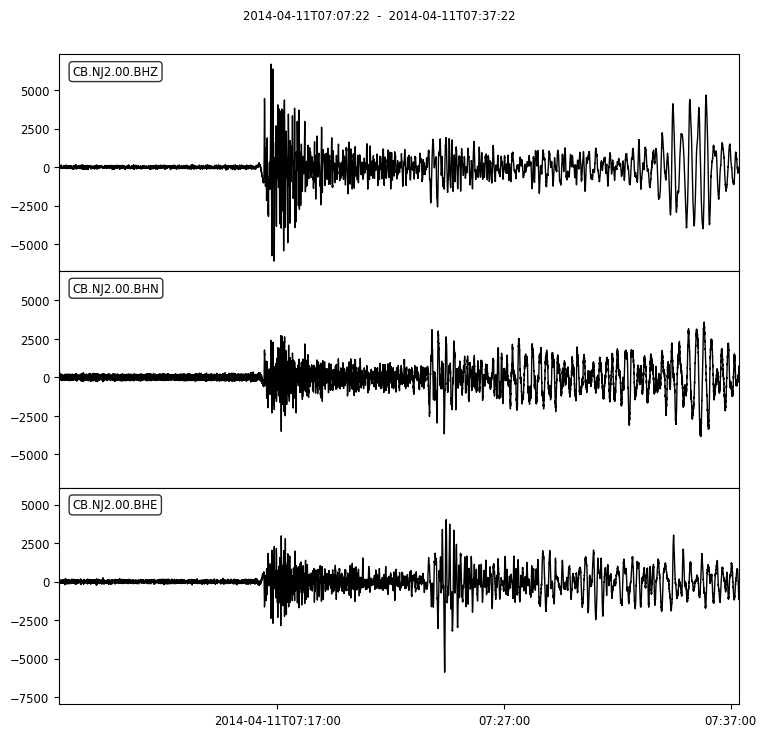

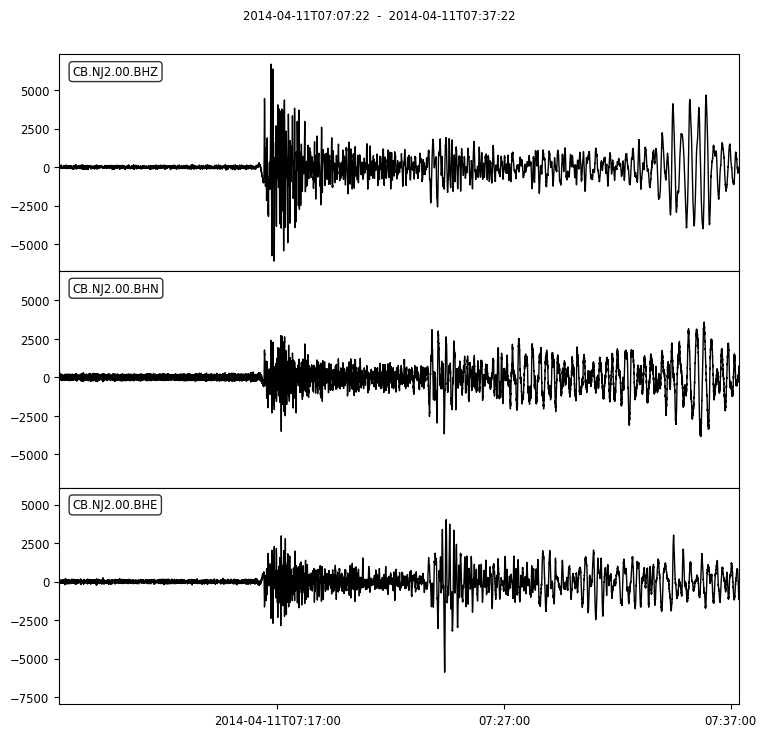

In [18]:
st_cmp = st.copy()

st.detrend()
st.filter("bandpass", freqmin=0.05, freqmax=2.0, zerophase=True)

# Plot for comparesion
st_cmp.plot()
st.plot()

### 4. Calculate the epicenter distance and back-azimuth
To trim the waveform or rotate the components, you can use the `seispy.distaz` to calculate the epicenter distance and back-azimuth.


In [23]:
da = seispy.distaz(st[0].stats.sac.stla, st[0].stats.sac.stlo, st[0].stats.sac.evla, st[0].stats.sac.evlo)
dis = da.delta
bazi = da.baz
ev_dep = st[0].stats.sac.evdp
print('Distance = %5.2f˚' % dis)
print('back-azimuth = %5.2f˚' % bazi)

Distance = 51.64˚
back-azimuth = 131.59˚


### 5. Rotation
Now you can rotate horizontal components (ENZ) into radial and transverse components (TRZ)

In [24]:
st_TRZ = st.copy().rotate('NE->RT', back_azimuth=bazi)

### 6. Estimating P arrival time and ray parameter by `obspy.taup`

In [7]:
from obspy.taup import TauPyModel

model = TauPyModel(model='iasp91')
arrivals = model.get_travel_times(ev_dep, dis, phase_list=['P'])
rayp = model.get_ray_paths(ev_dep, dis, phase_list=['P'])
P_arr = arrivals[0]
P_ray = rayp[0]

/Users/xumj/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/obspy/taup/tau_branch.py:496: UserWarning: Resizing a TauP array inplace failed due to the existence of other references to the array, creating a new array. See Obspy #2280.
  warnings.warn(msg)


### 7.Trim the waveforms for PRF
Then you cut 130 s long waveforms around P arrival time (from 10 s before to 120 s after theoretical P arrival times).

Text(0,0.5,'R')

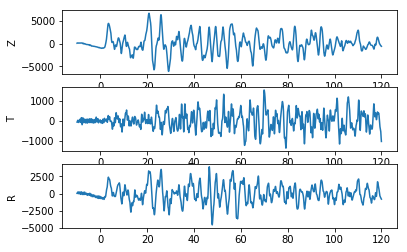

In [28]:
dt = st[0].stats.delta
shift = 10
time_after = 120

cut_pos_begin = int((P_arr.time - st[0].stats.sac.o - shift) / dt)
cut_pos_end = int((P_arr.time - st[0].stats.sac.o + time_after) / dt)

T = st_TRZ[0].data[cut_pos_begin:cut_pos_end+1]
R = st_TRZ[1].data[cut_pos_begin:cut_pos_end+1]
Z = st_TRZ[2].data[cut_pos_begin:cut_pos_end+1]

time_axis = np.linspace(-shift, time_after, T.shape[0])

ax1 = plt.subplot(3,1,1)
ax1.plot(time_axis, Z)
ax1.set_ylabel('Z')

ax2 = plt.subplot(3,1,2)
ax2.plot(time_axis, T)
ax2.set_ylabel('T')

ax3 = plt.subplot(3,1,3)
ax3.plot(time_axis, R)
ax3.set_ylabel('R')


### 8. Calculate PRF
`seispy.decov.decovit` provide a function with an iterative time-domain deconvolution method. Now let's Calculate a PRF. In this example we assume:
- Gauss factor = 2.0
- The maximum number of iterations = 400
- Minimum error = 0.001

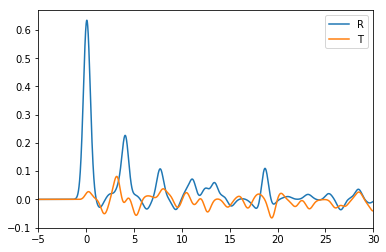

In [30]:
f0 = 2.0
tmax = 400
minderr = 0.001

PRF_R, RMS, it = seispy.decov.decovit(R, Z, dt, R.shape[0], shift, f0, tmax, minderr)
PRF_T, RMS, it = seispy.decov.decovit(T, Z, dt, T.shape[0], shift, f0, tmax, minderr)

plt.plot(time_axis, PRF_R)
plt.plot(time_axis, PRF_T)
plt.xlim([-5, 30])
plt.legend(['R', 'T'])

The figure shows PRFs in R and T components.